In [1]:
# Importing necessary modules from the Python standard library and external libraries
from pathlib import Path 
import matplotlib.pyplot as plt  
import numpy as np  
import pandas as pd  

import keras


In [2]:
# Reading the data files
dst = pd.read_csv("labels(dst).csv")

# Converting 'timedelta' column to Timedelta type
dst.timedelta = pd.to_timedelta(dst.timedelta)

# Setting multi-index with columns "period" and "timedelta" for 'dst' DataFrame
dst.set_index(["period", "timedelta"], inplace=True)
#Similar steps for reading other files
sunspots = pd.read_csv("sunspots_smooth train.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)
solar_wind = pd.read_csv("solar_wind train.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)


In [3]:
#First we analyse and visualise the data to actually understand the dataset and visualise the correlation of disturbance storm time index
#Also we analysing the data helps in pre-proccess the data more efficiently


In [4]:
print("Dst shape: ", dst.shape)
dst.head()

Dst shape:  (139872, 1)


dst
period  timedelta           
train_a 0 days 00:00:00   -7
        0 days 01:00:00  -10
        0 days 02:00:00  -10
        0 days 03:00:00   -6
        0 days 04:00:00   -2

In [5]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [6]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [7]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [8]:
#Describing solar wind data to check its statistical features
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [9]:
#Describing sun spot  data to check its statistical features
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

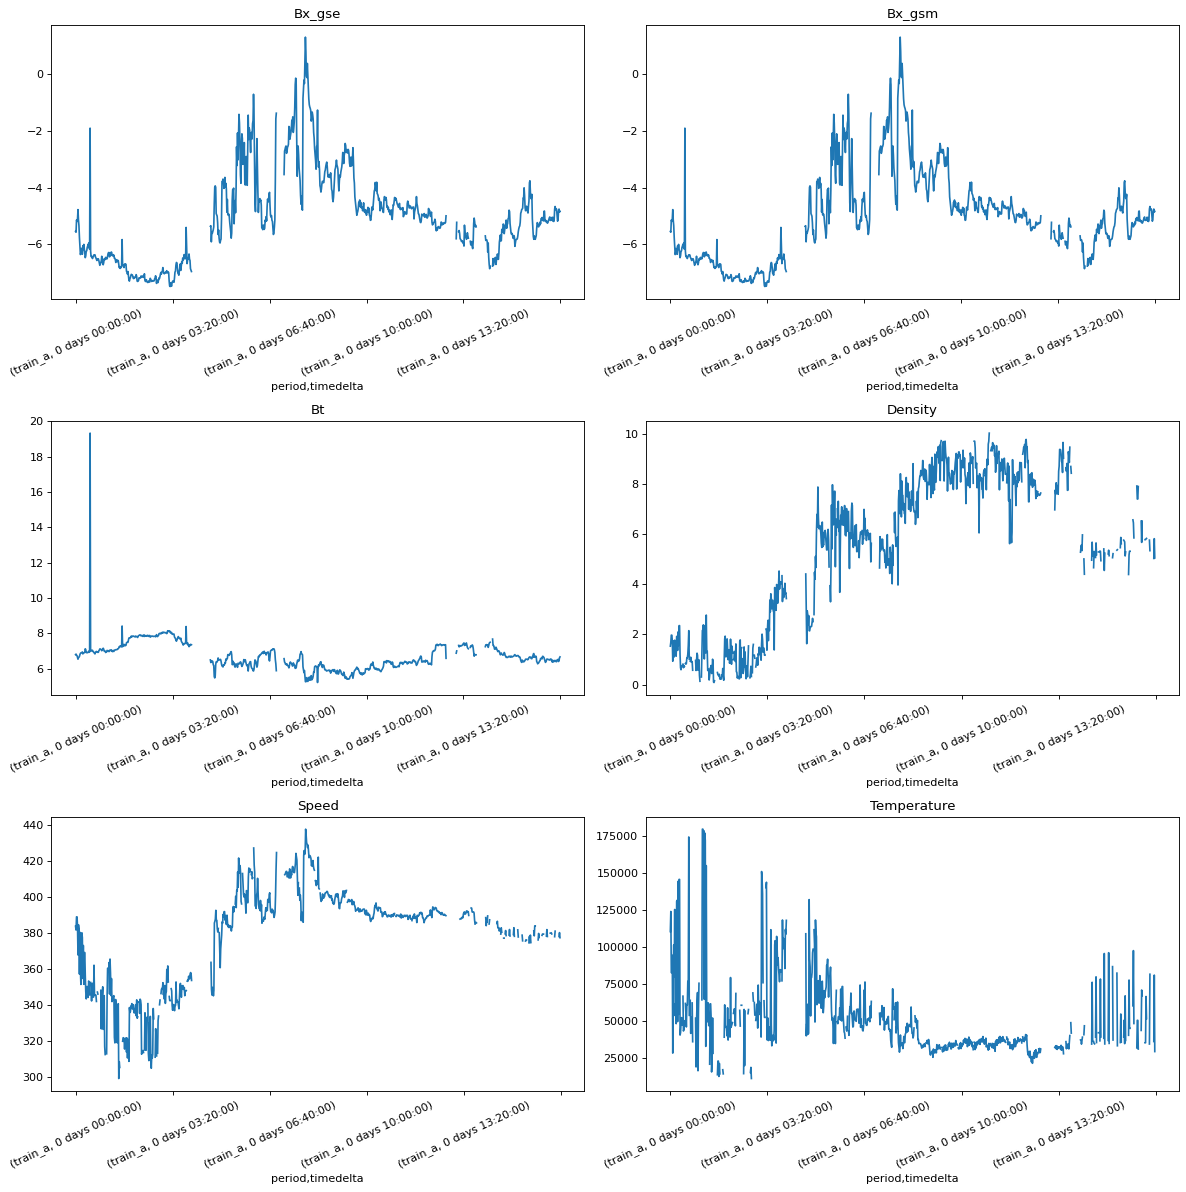

In [10]:
#Few visualisations of data described previously
#Here we analyse the teperature data specially it has a wide range of data value due to which we might have to use feautue scaling   
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [11]:
#Checking for the count of nulls in solar_wind
solar_wind.isna().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

In [12]:
#Dropping source column for finding correlation with other data
solar_wind= solar_wind.drop(columns=['source'])

C:\Users\DELL\AppData\Local\Temp\ipykernel_13288\972451669.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_corr = solar_wind.join(sunspots).join(dst).fillna(method="ffill").corr()


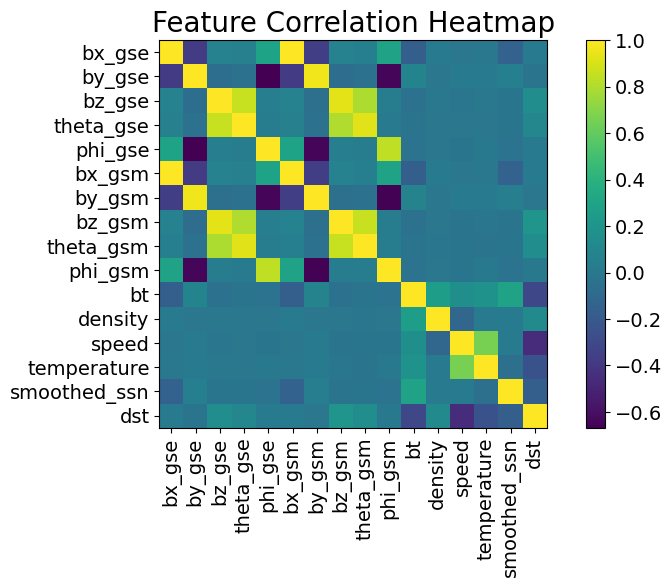

In [13]:
#Finding  correlation between data of dst ,solar wind,sunspots and visualising it through heatmap
feature_corr = solar_wind.join(sunspots).join(dst).fillna(method="ffill").corr()
#Used forwad fill technique to fill up null values for finding correlation without error
plt.figure(figsize=(10, 5))
plt.matshow(feature_corr, fignum=1)
plt.xticks(range(feature_corr.shape[1]), feature_corr, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(feature_corr.shape[1]),feature_corr.columns, fontsize=14)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=20)
plt.show()

In [14]:
#Plotting graph of datas which has the highest correlation value with dst for better visaualisation of data

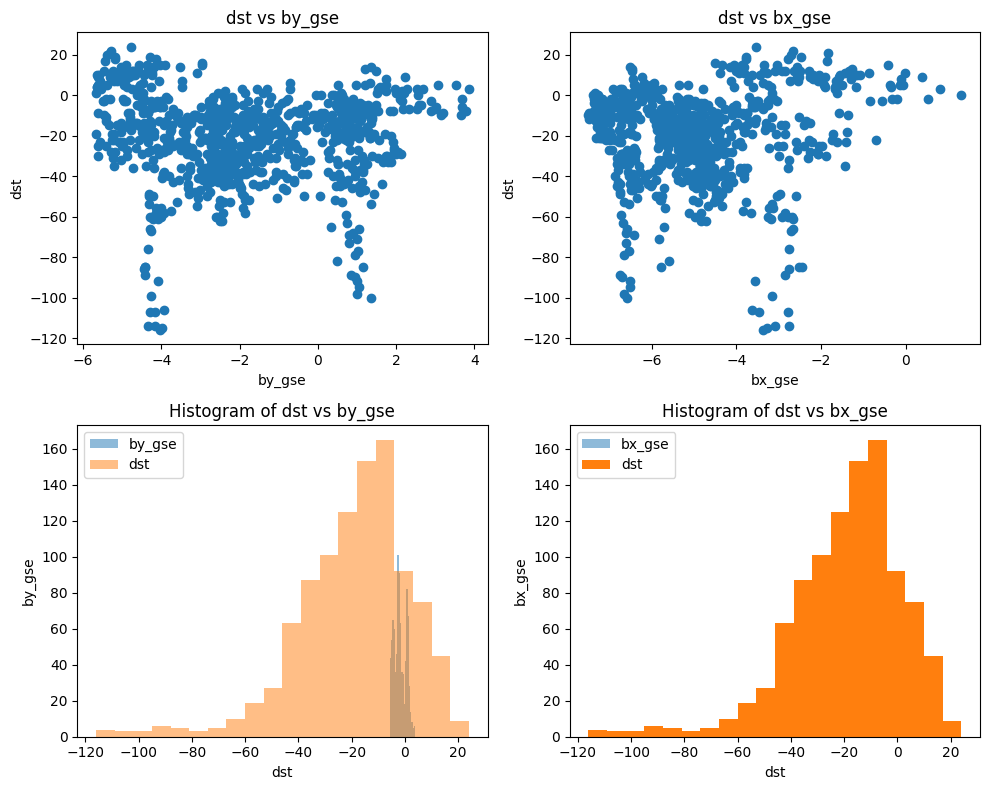

In [15]:

# Select the first 1000 rows from each DataFrame
df1_subset = solar_wind.head(1000)
df2_subset = dst.head(1000)

# Creating subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Ploting the first subplot (scatter plot)
axes[0, 0].scatter(df1_subset['by_gse'], df2_subset['dst'])
axes[0, 0].set_title('dst vs by_gse')
axes[0, 0].set_xlabel('by_gse')
axes[0, 0].set_ylabel('dst')
axes[0, 1].scatter(df1_subset['bx_gse'], df2_subset['dst'])
axes[0, 1].set_title('dst vs bx_gse')
axes[0, 1].set_xlabel('bx_gse')
axes[0, 1].set_ylabel('dst')


axes[1,0].hist(df1_subset['by_gse'],bins=20, alpha=0.5, label='by_gse')
axes[1,0].hist(df2_subset['dst'], bins=20,alpha=0.5, label='dst')


axes[1,0].set_xlabel('dst')
axes[1,0].set_ylabel('by_gse')
axes[1,0].set_title('Histogram of dst vs by_gse')

axes[1,0].legend()


axes[1,1].hist(df1_subset['bx_gse'],bins=20, alpha=0.5, label='bx_gse')
axes[1,1].hist(df2_subset['dst'], bins=20, label='dst')

axes[1,1].set_xlabel('dst')
axes[1,1].set_ylabel('bx_gse')
axes[1,1].set_title('Histogram of dst vs bx_gse')

axes[1,1].legend()

plt.tight_layout()

# Show the subplots
plt.show()


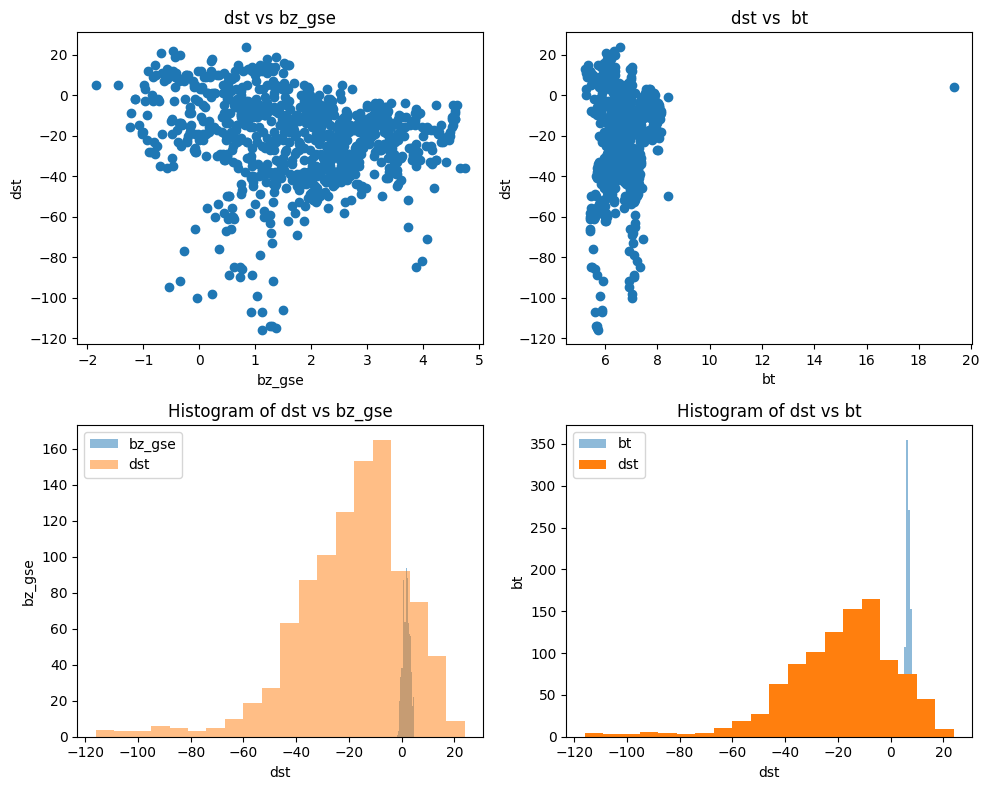

In [16]:

# Select the first 1000 rows from each DataFrame
df1_subset = solar_wind.head(1000)
df2_subset = dst.head(1000)

# Creating subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Ploting the first subplot (scatter plot)
axes[0, 0].scatter(df1_subset['bz_gse'], df2_subset['dst'])
axes[0, 0].set_title('dst vs bz_gse')
axes[0, 0].set_xlabel('bz_gse')
axes[0, 0].set_ylabel('dst')
axes[0, 1].scatter(df1_subset['bt'], df2_subset['dst'])
axes[0, 1].set_title('dst vs  bt')
axes[0, 1].set_xlabel('bt')
axes[0, 1].set_ylabel('dst')


axes[1,0].hist(df1_subset['bz_gse'],bins=20, alpha=0.5, label='bz_gse')
axes[1,0].hist(df2_subset['dst'], bins=20,alpha=0.5, label='dst')


axes[1,0].set_xlabel('dst')
axes[1,0].set_ylabel('bz_gse')
axes[1,0].set_title('Histogram of dst vs bz_gse')

axes[1,0].legend()


axes[1,1].hist(df1_subset['bt'],bins=20, alpha=0.5, label='bt')
axes[1,1].hist(df2_subset['dst'], bins=20, label='dst')

axes[1,1].set_xlabel('dst')
axes[1,1].set_ylabel('bt')
axes[1,1].set_title('Histogram of dst vs bt')

axes[1,1].legend()

plt.tight_layout()

# Show the subplots
plt.show()


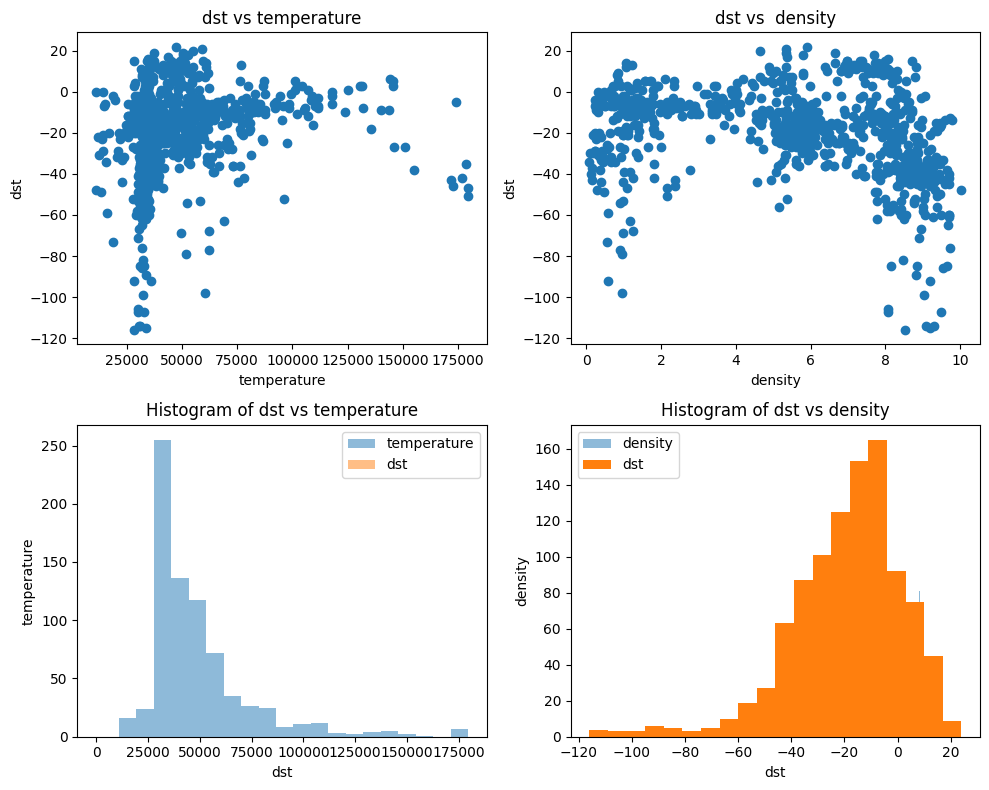

In [17]:

# Select the first 1000 rows from each DataFrame
df1_subset = solar_wind.head(1000)
df2_subset = dst.head(1000)

# Creating subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Ploting the first subplot (scatter plot)
axes[0, 0].scatter(df1_subset['temperature'], df2_subset['dst'])
axes[0, 0].set_title('dst vs temperature')
axes[0, 0].set_xlabel('temperature')
axes[0, 0].set_ylabel('dst')
axes[0, 1].scatter(df1_subset['density'], df2_subset['dst'])
axes[0, 1].set_title('dst vs  density')
axes[0, 1].set_xlabel('density')
axes[0, 1].set_ylabel('dst')


axes[1,0].hist(df1_subset['temperature'],bins=20, alpha=0.5, label='temperature')
axes[1,0].hist(df2_subset['dst'], bins=20,alpha=0.5, label='dst')


axes[1,0].set_xlabel('dst')
axes[1,0].set_ylabel('temperature')
axes[1,0].set_title('Histogram of dst vs temperature')

axes[1,0].legend()


axes[1,1].hist(df1_subset['density'],bins=20, alpha=0.5, label='density')
axes[1,1].hist(df2_subset['dst'], bins=20, label='dst')

axes[1,1].set_xlabel('dst')
axes[1,1].set_ylabel('density')
axes[1,1].set_title('Histogram of dst vs density')

axes[1,1].legend()

plt.tight_layout()

# Show the subplots
plt.show()


In [18]:
'''
# Select the first 1000 rows from each DataFrame
df1_subset = solar_wind.head(1000)
df2_subset = dst.head(1000)
df3_subset = sunspots.head(190)
df4_subset = dst.head(190)

# Creating subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Ploting the first subplot (scatter plot)
axes[0, 0].scatter(df1_subset['speed'], df2_subset['dst'])
axes[0, 0].set_title('dst vs speed')
axes[0, 0].set_xlabel('speed')
axes[0, 0].set_ylabel('dst')
axes[0, 1].scatter(df3_subset['smoothed_ssn'], df4_subset['dst'])
axes[0, 1].set_title('dst vs  smoothed sunspots')
axes[0, 1].set_xlabel('smoothed sunspots')
axes[0, 1].set_ylabel('dst')


axes[1,0].hist(df1_subset['speed'],bins=20, alpha=0.5, label='speed')
axes[1,0].hist(df2_subset['dst'], bins=20,alpha=0.5, label='dst')


axes[1,0].set_xlabel('dst')
axes[1,0].set_ylabel('speed')
axes[1,0].set_title('Histogram of dst vs speed')
axes[1,0].legend()


axes[1,1].hist(df3_subset['smoothed_ssn'],bins=20, alpha=0.5, label='smoothed sunspots')
axes[1,1].hist(df4_subset['dst'], bins=20, label='dst')

axes[1,1].set_xlabel('dst')
axes[1,1].set_ylabel('smoothed sunspots')
axes[1,1].set_title('Histogram of dst vs smoothed sunspots')

axes[1,1].legend()

plt.tight_layout()

# Show the subplots
plt.show()'''


"\n# Select the first 1000 rows from each DataFrame\ndf1_subset = solar_wind.head(1000)\ndf2_subset = dst.head(1000)\ndf3_subset = sunspots.head(190)\ndf4_subset = dst.head(190)\n\n# Creating subplots with a 2x2 grid\nfig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))\n\n# Ploting the first subplot (scatter plot)\naxes[0, 0].scatter(df1_subset['speed'], df2_subset['dst'])\naxes[0, 0].set_title('dst vs speed')\naxes[0, 0].set_xlabel('speed')\naxes[0, 0].set_ylabel('dst')\naxes[0, 1].scatter(df3_subset['smoothed_ssn'], df4_subset['dst'])\naxes[0, 1].set_title('dst vs  smoothed sunspots')\naxes[0, 1].set_xlabel('smoothed sunspots')\naxes[0, 1].set_ylabel('dst')\n\n\naxes[1,0].hist(df1_subset['speed'],bins=20, alpha=0.5, label='speed')\naxes[1,0].hist(df2_subset['dst'], bins=20,alpha=0.5, label='dst')\n\n\naxes[1,0].set_xlabel('dst')\naxes[1,0].set_ylabel('speed')\naxes[1,0].set_title('Histogram of dst vs speed')\naxes[1,0].legend()\n\n\naxes[1,1].hist(df3_subset['smoothed_ssn'],b

In [19]:
# Importing necessary functions for setting random seeds
from numpy.random import seed
from tensorflow.random import set_seed

# Setting the random seed for NumPy to ensure reproducibility
seed(2023)

# Setting the random seed for TensorFlow to ensure reproducibility
set_seed(2024)

In [20]:
#Now we perform feature scaling of data which has the highest correlation value with dst

In [21]:
from sklearn.preprocessing import StandardScaler

# subset of solar wind features to use for modeling
solar_wind_correlated_features = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

# we'll use all of the features, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in solar_wind_correlated_features]
    + [col + "_std" for col in solar_wind_correlated_features]
    + ["smoothed_ssn"]
)


def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # using forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolating between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # grouping by the floor of each hour using timedelta index+
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flattening hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Making subset the data
        - Aggregating hourly
        - Joining solar wind and sunspot data
        - Scaling using standard scaler
        - Imputing missing values
    """
    # selecting the features to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregating solar wind data and joining it with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtracting mean and dividing it by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # imputing missing values
    imputed = impute_features(normalized)
    return imputed, scaler

In [22]:
# Calling the preprocess_features function with solar_wind, sunspots, and a specified subset of features
features, scaler = preprocess_features(solar_wind, sunspots, subset=solar_wind_correlated_features)

print(features.shape)
features.head()

(139872, 15)


C:\Users\DELL\AppData\Local\Temp\ipykernel_13288\156856119.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [23]:
# checking to make sure missing values are filled
assert (features.isna().sum() == 0).all()

In [24]:
#Modifying the shape of labels dst by data shifting as we want to predict dst of 1 hour ahead also
#Hence we can do multi-step prediction by providing it both steps
# List of column names for the labels
YCOLS = ["t0", "t1"]

# Function to process labels based on the 'dst' DataFrame
def process_labels(dst):
    # Creating a copy of the 'dst' DataFrame
    y = dst.copy()

    # Shifting 'dst' values within each period to create time-lagged labels 't0' and 't1'
    y["t0"] = y.groupby("period").dst.shift(-1)
    y["t1"] = y.groupby("period").dst.shift(-2)
    return y[YCOLS]
labels = process_labels(dst)
labels.head()


t0    t1
period  timedelta                  
train_a 0 days 00:00:00 -10.0 -10.0
        0 days 01:00:00 -10.0  -6.0
        0 days 02:00:00  -6.0  -2.0
        0 days 03:00:00  -2.0   3.0
        0 days 04:00:00   3.0   5.0

In [25]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [26]:
#Spliting data so that the model can't read every data and can get fresh data for the test phase
def get_train_test_val(data, test_per_period, val_per_period):
    """Spliting data across periods into train, test, and validation"""
    # assigning the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assigning the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)


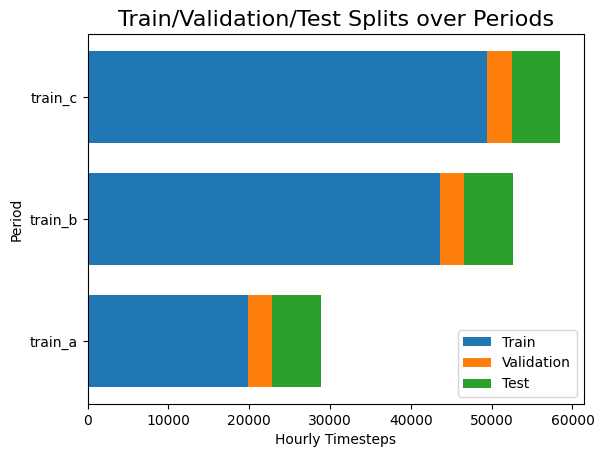

In [27]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_counts = [len(df) for _, df in train.groupby("period")]
val_counts = [len(df) for _, df in val.groupby("period")]
test_counts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_counts, width)
p2 = plt.barh(ind, val_counts, width, left=train_counts)
p3 = plt.barh(ind, test_counts, width, left=np.add(val_counts, train_counts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array


data_config = {
    "timesteps": 32,
    "batch_size": 32,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset


train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 3523
Number of val batches: 276


In [29]:
import tensorflow as tf

In [30]:
from keras.layers import Dense, LSTM
from keras.models import Sequential

# setting  our model configuration
model_config = {"n_epochs": 16, "n_neurons": 512, "dropout": 0.4, "stateful": False}

model = Sequential()
model.add(
    LSTM(
        model_config["n_neurons"],
        # usually set to (batch_size, sequence_length, n_features)
        # setting the batch size to None allows for variable length batches
        batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],
    )
)
model.add(Dense(len(YCOLS)))
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1081344   
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1082370 (4.13 MB)
Trainable params: 1082370 (4.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
for x, y in train_ds:
    print(f"Shape of input sequences (x): {x.shape}")
    print(f"Shape of output targets (y): {y.shape}")
    break  # Prints only the shape of the first batch

Shape of input sequences (x): (32, 32, 15)
Shape of output targets (y): (32, 2)


In [32]:
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=0,
    shuffle=False,
    validation_data=val_ds,
)

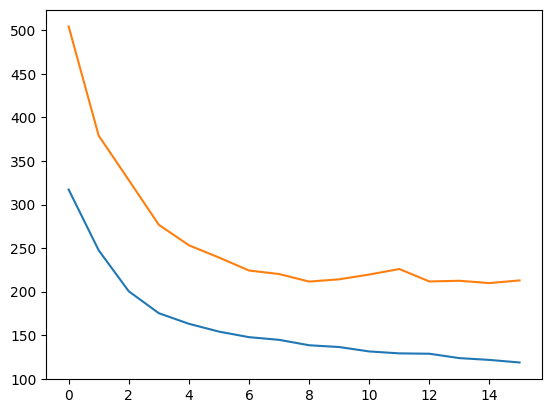

In [35]:
for name, values in history.history.items():
    plt.plot(values)

In [37]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])


In [38]:
test_ds = timeseries_dataset_from_df(test, data_config["batch_size"])

In [39]:
pred=model.predict(test_ds)

558/558 [==============================] - 39s 67ms/step


In [40]:
pred

array([[-13.951528 , -14.111028 ],
       [-14.845534 , -14.985103 ],
       [-14.726985 , -15.017859 ],
       ...,
       [ -4.459772 ,  -5.7045355],
       [ -3.7288845,  -5.2598634],
       [ -5.8161125,  -6.5764794]], dtype=float32)

In [41]:
mse = model.evaluate(test_ds)
print(f"Test RMSE: {mse**(0.5):.2f}")

558/558 [==============================] - 29s 52ms/step - loss: 200.8739
Test RMSE: 14.17


In [42]:
import json
import pickle

model.save("model")

with open("scaler.pck", "wb") as f:
    pickle.dump(scaler, f)

data_config["solar_wind_subset"] = solar_wind_correlated_features
print(data_config)
with open("config.json", "w") as f:
    json.dump(data_config,f)

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


{'timesteps': 32, 'batch_size': 32, 'solar_wind_subset': ['bt', 'temperature', 'bx_gse', 'by_gse', 'bz_gse', 'speed', 'density']}
